# Overview
 - Finding centers of similarity using k-means algorithm
 - Using a bottom-up approach to build hierarchical cluster trees
 - Identify arbitrary shapes of objects using a density-based clustering approach

### Grouping objects by similiarity using k-means

In [1]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=150,
                 n_features=2,
                 centers=3,
                 cluster_std=0.5,
                 shuffle=True,
                 random_state=0)

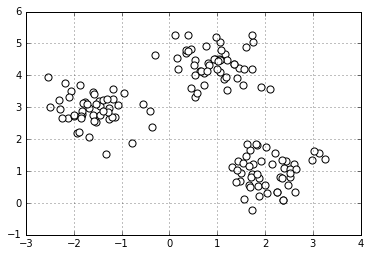

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:,0],
            X[:,1],
            c='white',
            marker='o',
            s=50)
plt.grid()
plt.show()
## 150 random generated points roughly grouped into three regions

In [3]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,
           init='random',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=0)
y_km = km.fit_predict(X)

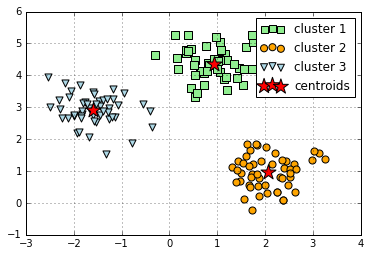

In [4]:
## visualize clusters and centroids
plt.scatter(X[y_km==0,0],
            X[y_km==0,1],
            s=50,
            c='lightgreen',
            marker='s',
            label='cluster 1')
plt.scatter(X[y_km==1,0],
            X[y_km==1,1],
            s=50,
            c='orange',
            marker='o',
            label='cluster 2')
plt.scatter(X[y_km==2,0],
            X[y_km==2,1],
            s=50,
            c='lightblue',
            marker='v',
            label='cluster 3')
plt.scatter(km.cluster_centers_[:,0],
            km.cluster_centers_[:,1],
            s=250,
            marker='*',
            c='red',
            label='centroids')
plt.legend()
plt.grid()
plt.show()

### Hard versus soft clustering
<u>Hard clustering</u> - each sample assigned to exaclty <b>one</b> cluster. (classic k-means)
<u>Soft clustering - fuzzy clustering</u>-- assign sample to one or more clusters. (fuzzy C-means)

### Using the elbow mehtod to find the optimal number of clusters

In [5]:
## within cluster SSE (distortion) for comparing performance of 
## different k-means clusterings; accesible via inertia_ attribute 
## from k-means model
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


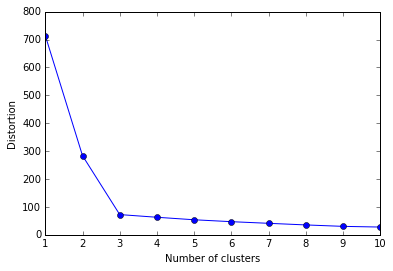

In [6]:
## ploting the distortions to illustrate elbow method meaning
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i,
               init='k-means++',
               n_init=10,
               max_iter=300,
               random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
## can tell the elbow is located at k=3
## providing evidence that k=3 is good choice for this dataset

### Quantifying quality of clustering via silhouette plots

In [7]:
## crreat plot of the silhouette coefficients
km = KMeans(n_clusters=3,
           init='k-means++',
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=0)
y_km = km.fit_predict(X)

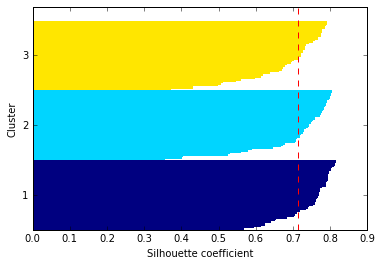

In [8]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km,
                                    metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), 
             c_silhouette_vals, 
             height=1.0, 
             edgecolor='none', 
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg,
            color="red", 
            linestyle="--") 
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()
## shows good clustering!

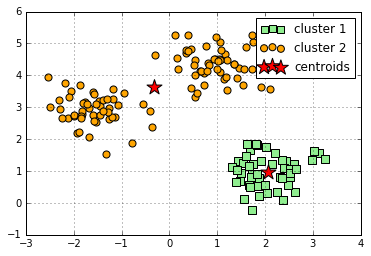

In [9]:
## looking at relatively bad clusting now, here with two centroids
km = KMeans(n_clusters=2, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

plt.scatter(X[y_km==0,0], 
            X[y_km==0,1], 
            s=50, c='lightgreen', 
            marker='s', 
            label='cluster 1')
plt.scatter(X[y_km==1,0], 
            X[y_km==1,1], 
            s=50, 
            c='orange', 
            marker='o', 
            label='cluster 2')
plt.scatter(km.cluster_centers_[:,0], 
            km.cluster_centers_[:,1], 
            s=250, 
            marker='*', 
            c='red', 
            label='centroids')
plt.legend()
plt.grid()
plt.show()

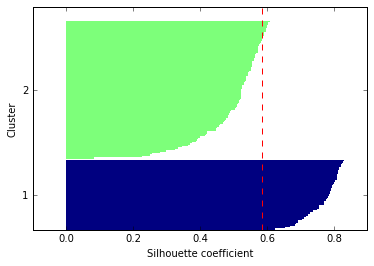

In [10]:
## now looking at a silhouette plot of to evaluate these results
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, 
                                     y_km, 
                                     metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(i / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), 
             c_silhouette_vals, 
             height=1.0, 
             edgecolor='none', 
             color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()
## visibly different lengths and widths, evidence for suboptimal
## clustering

## Organizing clusters as hierarchical tree
##### (Hierarchical Clustering)

In [11]:
## agglomerative clustering
## generate some random data to work with
## rows -> observations (IDs 0-4) 
## cols -> different features(X,Y,Z)
import pandas as pd
import numpy as np
np.random.seed(123)
variables = ['X', 'Y', 'Z']
labels = ['ID_0','ID_1','ID_2','ID_3','ID_4']
X = np.random.random_sample([5,3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


In [12]:
## computing the distance matrix
## use pdist from scipy's spatial.distance
from scipy.spatial.distance import pdist, squareform
row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                       columns=labels, index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [13]:
## apply complete linkage agglomeration to clusters
## using linkage from scipy's cluster.hierarchy (returns linkage matrix)
from scipy.cluster.hierarchy import linkage
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean')
    Performs hierarchical/agglomerative clustering on the condensed
    distance matrix y.
    
    y must be a :math:`{n \choose 2}` sized
    vector where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    An :math:`(n-1)` by 4  matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents the number of original
    observations in the newly formed cluster.
    
    The following linkage methods are used to compute the distance
  

In [14]:
## INCORRECT approach - using squareform distance matrix
from scipy.cluster.hierarchy import linkage
# incorrect way
# row_clusters = linkage(row_dist, method='complete',
#                       metric='euclidead')
## CORRECT approaches
# use condensed distance matrix from pdist
row_clusters = linkage(pdist(df, metric='euclidean'),
                      method='complete')
## OR
# use input sample matrix
row_clusters = linkage(df.values, method='complete',
                      metric='euclidean')

In [15]:
## look at cluster results
pd.DataFrame(row_clusters,
            columns=['row label 1',
                    'row label 2',
                    'distance',
                    'no. of items in clust.'],
            index=['cluster %d' % (i+1) for i in
                  range(row_clusters.shape[0])])
## first and second columns denote most dissimilar memebers in cluster
## thrid col distance between, third members in each cluster

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


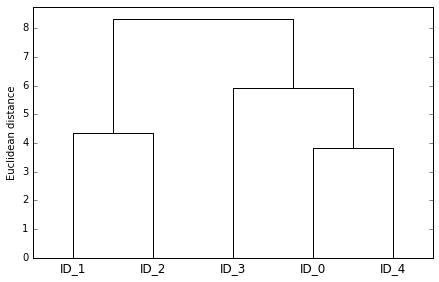

In [16]:
## see ^^^ results in dendrogram
from scipy.cluster.hierarchy import dendrogram
# make dendrogram black (part 1/2)
from scipy.cluster.hierarchy import set_link_color_palette
set_link_color_palette(['black'])
row_dendr = dendrogram(row_clusters, 
                      labels=labels,
#                       make dendrogram black (part 2/2)
                      color_threshold=np.inf
                      )
plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()


### Attaching dendrogram to heat map

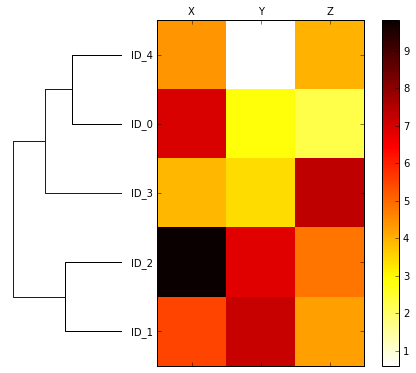

In [17]:
# Step 1: create new 'figure' object define x,y axis position, 
#         width and height of dendrogram via 'add_axes'. 
#         rotate dendrogram 90degrees counter-clockwise:

fig = plt.figure(figsize=(8,8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')

# Step 2: we reorder our data in initial DataFrame according 
#         to clustering labels accessed from the dendrogram object 
#         (which is essentially a dict) via leaves key

df_rowclust = df.ix[row_dendr['leaves'][::-1]]

# Step 3: construct heat map from reodered DataFrame and 
#         position it next to dedrogram:

axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])
cax = axm.matshow(df_rowclust, interpolation='nearest',
                 cmap='hot_r')

# Step 4: lastly we modify aesthetics of heat map removing axis 
#         ticks and hiding axis spines. Also add color bar and 
#         assign the feature and sample names to the x and y tick 
#         labels, respectively:

axd.set_xticks([])
axd.set_yticks([])

for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

# plt.savefig('./figures/heatmap.png', dpi=300)
plt.show()

In [18]:
## Applying agglomerative clustering in scikit-learn
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(n_clusters=2,
                            affinity='euclidean',
                            linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 1 1 0 0]


## Locating regions of high density via DBSCAN

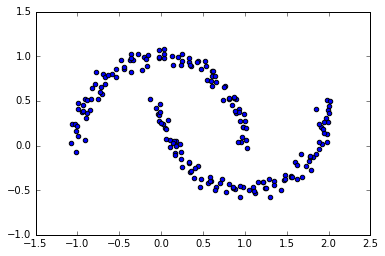

In [19]:
## illustrative example with new half-moon-shaped structure dataset
## to compare k-means clsustering, hierarchical clustering and DBSCAN
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200,
                 noise=0.05,
                 random_state=0)
plt.scatter(X[:,0], X[:,1])
plt.show()

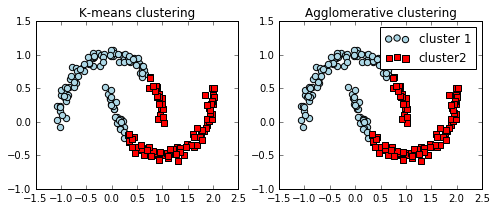

In [21]:
## k-means and complete linkage
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3))
km = KMeans(n_clusters=2,
           random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km==0, 0],
            X[y_km==0, 1],
            c='lightblue',
            marker='o',
            s=40,
            label='cluster 1')
ax1.scatter(X[y_km==1, 0],
            X[y_km==1, 1],
            c='red',
            marker='s',
            s=40,
            label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_km==0, 0],
           X[y_km==0, 1],
           c='lightblue',
           marker='o',
           s=40,
           label='cluster 1')
ax2.scatter(X[y_km==1, 0],
           X[y_km==1, 1],
           c='red',
           marker='s',
           s=40,
           label='cluster2')
ax2.set_title('Agglomerative clustering')
plt.legend()
plt.show()


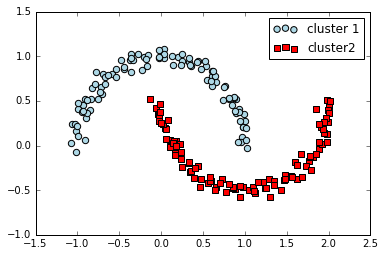

In [24]:
## DBSCAN
### see if can find 2 half moons, using density-based approach
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.2,
            min_samples=5,
            metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db==0, 0],
           X[y_db==0, 1],
           c='lightblue',
           marker='o',
           s=40,
           label='cluster 1')
plt.scatter(X[y_db==1, 0],
           X[y_db==1, 1],
           c='red',
           marker='s',
           s=40,
           label='cluster2')
plt.legend()
plt.show()

# Summary
In this chapter, you learned about three different clustering algorithms that can help us with the discovery of hidden structures or information in data. We started this chapter with a prototype-based approach, k-means, which clusters samples into spherical shapes based on a specified number of cluster centroids. Since clustering is an unsupervised method, we do not enjoy the luxury of ground truth labels to evaluate the performance of a model. Thus, we looked at useful intrinsic performance metrics such as the elbow method or silhouette analysis as an attempt to quantify the quality of clustering.

We then looked at a different approach to clustering: agglomerative hierarchical clustering. Hierarchical clustering does not require specifying the number of clusters upfront, and the result can be visualized in a dendrogram representation, which can help with the interpretation of the results. The last clustering algorithm that we saw in this chapter was DBSCAN, an algorithm that groups points based on local densities and is capable of handling outliers and identifying nonglobular shapes.